### 导入库,定义一些全局常量

In [1]:
import torch
torch.cuda.is_available()

True

In [2]:
!pip install transformers

     |████████████████████████████████| 573kB 7.5MB/s 
     |████████████████████████████████| 3.7MB 18.0MB/s 
     |████████████████████████████████| 1.0MB 39.3MB/s 
     |████████████████████████████████| 870kB 57.5MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.38-cp36-none-any.whl size=884628 sha256=32414091783bfbf696291bc0a9ded2dc72e34102c5d0c046d04926ddc19b8c30
  Stored in directory: /root/.cache/pip/wheels/6d/ec/1a/21b8912e35e02741306f35f66c785f3afe94de754a0eaf1422
Successfully built sacremoses


In [0]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.nn import CrossEntropyLoss, MSELoss
import torch.nn.functional as F

import torch.optim as optim
from torchtext.data import BucketIterator

from torch.utils.data import DataLoader, RandomSampler, SequentialSampler, TensorDataset
from torch.utils.data.distributed import DistributedSampler
from tqdm import tqdm, trange

In [0]:
from transformers import (
    WEIGHTS_NAME,
    AdamW,
    get_linear_schedule_with_warmup,
    BertConfig,
    BertModel,
    BertPreTrainedModel,
    BertTokenizer,)

In [0]:
from transformers import glue_convert_examples_to_features as convert_examples_to_features
from transformers import glue_output_modes as output_modes
from transformers import glue_processors as processors
from transformers.data.processors.utils import InputExample, DataProcessor

In [0]:
import logging
logger=logging.getLogger(__name__)

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
MODEL_CLASSES={
    "bert":(BertConfig,BertTokenizer),
}

my_label_list=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
MAX_SEQ_LENGTH=200


### 这块可以暂时不要了

In [0]:
train_raw = pd.read_csv('/content/drive/My Drive/Data/consumer_complaints.csv')
train_raw.head()

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (5,11) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,date_received,product,sub_product,issue,sub_issue,consumer_complaint_narrative,company_public_response,company,state,zipcode,tags,consumer_consent_provided,submitted_via,date_sent_to_company,company_response_to_consumer,timely_response,consumer_disputed?,complaint_id
0,08/30/2013,Mortgage,Other mortgage,"Loan modification,collection,foreclosure",NaN,NaN,NaN,U.S. Bancorp,CA,95993,NaN,NaN,Referral,09/03/2013,Closed with explanation,Yes,Yes,511074
1,08/30/2013,Mortgage,Other mortgage,"Loan servicing, payments, escrow account",NaN,NaN,NaN,Wells Fargo & Company,CA,91104,NaN,NaN,Referral,09/03/2013,Closed with explanation,Yes,Yes,511080
2,08/30/2013,Credit reporting,NaN,Incorrect information on credit report,Account status,NaN,NaN,Wells Fargo & Company,NY,11764,NaN,NaN,Postal mail,09/18/2013,Closed with explanation,Yes,No,510473
3,08/30/2013,Student loan,Non-federal student loan,Repaying your loan,Repaying your loan,NaN,NaN,"Navient Solutions, Inc.",MD,21402,NaN,NaN,Email,08/30/2013,Closed with explanation,Yes,Yes,510326
4,08/30/2013,Debt collection,Credit card,False statements or representation,Attempted to collect wrong amount,NaN,NaN,Resurgent Capital Services L.P.,GA,30106,NaN,NaN,Web,08/30/2013,Closed with explanation,Yes,Yes,511067


In [0]:
train_raw.shape

(555957, 18)

In [0]:
train_raw = train_raw[train_raw.consumer_complaint_narrative.notnull()]
train_raw.shape

(66806, 18)

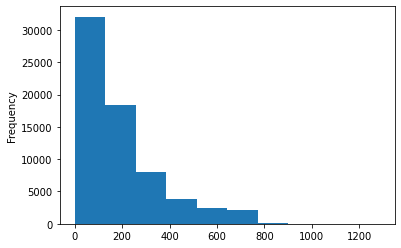

In [0]:
train_raw.consumer_complaint_narrative.apply(lambda x: len(x.split())).plot(kind='hist')

In [0]:
train_raw['len_txt'] =train_raw.consumer_complaint_narrative.apply(lambda x: len(x.split()))

In [0]:
train_raw.shape

(66806, 19)

In [0]:
train_raw = train_raw[train_raw.len_txt >249]
train_raw.shape

(17142, 19)

In [0]:
train_raw = train_raw[['consumer_complaint_narrative', 'product']]
train_raw.reset_index(inplace=True, drop=True)
train_raw.head()

,consumer_complaint_narrative,product
0,In XX/XX/XXXX my wages that I earned at my job...,Mortgage
1,XXXX was submitted XX/XX/XXXX. At the time I s...,Mortgage
2,I spoke to XXXX of green tree representatives ...,Mortgage
3,i opened XXXX Bank of America credit cards 15-...,Credit card
4,I applied for a loan with XXXX XXXX and had pu...,Consumer Loan


In [0]:
train_raw.at[train_raw['product'] == 'Credit reporting', 'product'] = 'Credit reporting, credit repair services, or other personal consumer reports'
train_raw.at[train_raw['product'] == 'Credit card', 'product'] = 'Credit card or prepaid card'
train_raw.at[train_raw['product'] == 'Prepaid card', 'product'] = 'Credit card or prepaid card'
train_raw.at[train_raw['product'] == 'Payday loan', 'product'] = 'Payday loan, title loan, or personal loan'
train_raw.at[train_raw['product'] == 'Virtual currency', 'product'] = 'Money transfer, virtual currency, or money service'
train_raw.head()

,consumer_complaint_narrative,product
0,In XX/XX/XXXX my wages that I earned at my job...,Mortgage
1,XXXX was submitted XX/XX/XXXX. At the time I s...,Mortgage
2,I spoke to XXXX of green tree representatives ...,Mortgage
3,i opened XXXX Bank of America credit cards 15-...,Credit card or prepaid card
4,I applied for a loan with XXXX XXXX and had pu...,Consumer Loan


In [0]:
train_raw=train_raw.rename(columns = {'consumer_complaint_narrative':'text', 'product':'label'})
train_raw.head()

NameError: ignored

In [0]:
train_raw.to_csv("/content/drive/My Drive/Data/consumer_complaint_narrative.csv",index=0)

### 读入csv,初步处理数据, 处理完获得 val(3429, 2), train(13713, 2)

In [9]:
train_raw = pd.read_csv('/content/drive/My Drive/Data/consumer_complaint_narrative.csv')
train_raw.head()

,text,label
0,In XX/XX/XXXX my wages that I earned at my job...,Mortgage
1,XXXX was submitted XX/XX/XXXX. At the time I s...,Mortgage
2,I spoke to XXXX of green tree representatives ...,Mortgage
3,i opened XXXX Bank of America credit cards 15-...,Credit card or prepaid card
4,I applied for a loan with XXXX XXXX and had pu...,Consumer Loan


In [10]:
from sklearn.preprocessing import LabelEncoder

LE = LabelEncoder()
train_raw['label'] = LE.fit_transform(train_raw['label'])
train_raw.head()

,text,label
0,In XX/XX/XXXX my wages that I earned at my job...,6
1,XXXX was submitted XX/XX/XXXX. At the time I s...,6
2,I spoke to XXXX of green tree representatives ...,6
3,i opened XXXX Bank of America credit cards 15-...,2
4,I applied for a loan with XXXX XXXX and had pu...,1


In [11]:
train = train_raw.copy()
train = train.reindex(np.random.permutation(train.index))
train.head()

,text,label
9042,"I became a victim from XXXX/broker "" s name [ ...",6
5289,XXXX XXXX XXXX XXXX listed collection accounts...,3
3491,This complaint is about SETERUS Mortgage Servi...,6
8989,I WISH TO FILE A COMPLAINT AGAINST XXXX. DBA N...,6
9620,I have a mortgage with Bank of America. I curr...,6


In [0]:
import re
def clean_txt(text):
  text = re.sub("'", "",text)
  text=re.sub("(\\W)+"," ",text)    
  return text

In [13]:
train['text']  = train.text.apply(clean_txt)
train.head()

,text,label
9042,I became a victim from XXXX broker s name XXXX...,6
5289,XXXX XXXX XXXX XXXX listed collection accounts...,3
3491,This complaint is about SETERUS Mortgage Servi...,6
8989,I WISH TO FILE A COMPLAINT AGAINST XXXX DBA NE...,6
9620,I have a mortgage with Bank of America I curre...,6


In [14]:
from sklearn.model_selection import train_test_split
train, val = train_test_split(train, test_size=0.2, random_state=35)
train.head()

,text,label
868,I have a Regular checking account with Bank of...,0
12514,We have XXXX mortgages with Greentree Servicin...,4
918,Extremely poor customer service tracking monit...,1
10801,My issue deals with my mortgage company and fl...,6
15022,I applied for a loan modification to save my h...,6


In [15]:
train.reset_index(drop=True, inplace=True)
train.head(2)

,text,label
0,I have a Regular checking account with Bank of...,0
1,We have XXXX mortgages with Greentree Servicin...,4


In [16]:
val.reset_index(drop=True, inplace=True)
val.head(2)

,text,label
0,I received a credit card statement from Capita...,2
1,I am executor of my father s estate My father ...,6


In [17]:
val.shape, train.shape

((3429, 2), (13713, 2))

### 按照每200大小切割文本,处理完获得 train_df(31698,2), val_df(7927,2)

In [0]:
def get_split(text):
    l_total = []
    l_parcial = []
    if len(text.split())//150 >0:
      n = len(text.split())//150
    else: 
      n = 1
    for w in range(n):
      if w == 0:
        l_parcial = text.split()[:200]
        l_total.append(" ".join(l_parcial))
      else:
        l_parcial = text.split()[w*150:w*150 + 200]
        l_total.append(" ".join(l_parcial))
    return l_total

In [19]:
train['text_split'] = train['text'].apply(get_split)
train.head()

,text,label,text_split
0,I have a Regular checking account with Bank of...,0,[I have a Regular checking account with Bank o...
1,We have XXXX mortgages with Greentree Servicin...,4,[We have XXXX mortgages with Greentree Servici...
2,Extremely poor customer service tracking monit...,1,[Extremely poor customer service tracking moni...
3,My issue deals with my mortgage company and fl...,6,[My issue deals with my mortgage company and f...
4,I applied for a loan modification to save my h...,6,[I applied for a loan modification to save my ...


In [20]:
val['text_split'] = val['text'].apply(get_split)
val.head()

,text,label,text_split
0,I received a credit card statement from Capita...,2,[I received a credit card statement from Capit...
1,I am executor of my father s estate My father ...,6,[I am executor of my father s estate My father...
2,In XX XX XXXX I financed a Flat Screen TV thro...,1,[In XX XX XXXX I financed a Flat Screen TV thr...
3,1 When loan documents were signed XX XX XXXX B...,6,[1 When loan documents were signed XX XX XXXX ...
4,OCWEN is the servicing bank has held homeowner...,6,[OCWEN is the servicing bank has held homeowne...


In [21]:
train_l = []  # 分割好的文本
label_l = []  # 每段文本的label
index_l =[]   # 该段文本属于未分割前的哪个文本. 比如是3, 那就表明此段文本是属于未分割前的第4条数据
for idx,row in train.iterrows():
  for l in row['text_split']:
    train_l.append(l)
    label_l.append(row['label'])
    index_l.append(idx)
len(train_l), len(label_l), len(index_l)

(31600, 31600, 31600)

In [22]:
val_l = []
val_label_l = []
val_index_l = []
for idx,row in val.iterrows():
  for l in row['text_split']:
    val_l.append(l)
    val_label_l.append(row['label'])
    val_index_l.append(idx)
len(val_l), len(val_label_l), len(val_index_l)

(8025, 8025, 8025)

In [23]:
train_df = pd.DataFrame({'text':train_l, 'label':label_l})
train_df.head()

,text,label
0,I have a Regular checking account with Bank of...,0
1,We have XXXX mortgages with Greentree Servicin...,4
2,Writ of Possession which is required by Vermon...,4
3,XXXX XXXX was the officer who returned our cal...,4
4,you know the plaintiff s attorney finally resp...,4


In [24]:
val_df = pd.DataFrame({'text':val_l, 'label':val_label_l})
val_df.head()

,text,label
0,I received a credit card statement from Capita...,2
1,I am executor of my father s estate My father ...,6
2,In XX XX XXXX I financed a Flat Screen TV thro...,1
3,statement which I rarely did since i would jus...,1
4,1 When loan documents were signed XX XX XXXX B...,6


In [0]:
train_InputExamples = train_df.apply(lambda x: InputExample(guid=None,
                                                                   text_a = x['text'], 
                                                                   text_b = None, 
                                                                   label = x['label']), axis = 1)

val_InputExamples = val_df.apply(lambda x: InputExample(guid=None, 
                                                                   text_a = x['text'], 
                                                                   text_b = None, 
                                                                   label = x['label']), axis = 1)

### 定义模型

In [0]:
class BertForClassification(BertPreTrainedModel):
    def __init__(self, config):
        super().__init__(config)
        self.num_labels = 10

        self.bert = BertModel(config)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.classifier = nn.Linear(config.hidden_size, self.num_labels)

        self.init_weights()

    def forward(
        self,
        input_ids=None,  #输入的id,模型会帮你把id转成embedding
        attention_mask=None,   #attention里的mask
        token_type_ids=None,    # [CLS]A[SEP]B[SEP] 就这个A还是B, 有的话就全1, 没有就0
        position_ids=None,     # 位置id
        head_mask=None,       # 哪个head需要被mask掉
        inputs_embeds=None,   # 可以选择不输入id,直接输入embedding
        labels=None,          # 做分类时需要的label
    ):

        outputs = self.bert(
            input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            position_ids=position_ids,
            head_mask=head_mask,
            inputs_embeds=inputs_embeds,
        )

        sequence_output, pooled_output=outputs[:2]

        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)

        
        outputs = (logits, pooled_output, sequence_output,)

        if labels is not None:
            
            if self.num_labels == 1:
                #  We are doing regression
                loss_fct = MSELoss()
                loss = loss_fct(logits.view(-1), labels.view(-1))
            else:
                loss_fct = CrossEntropyLoss()
                loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
            outputs = (loss,) + outputs

        
        return outputs  # loss, logits, pooled_output, sequence_output


### 载入预训练模型, 准备训练数据, 训练, 保存模型

In [0]:
# 1.载入预训练模型
args={"model_name_or_path": "/content/drive/My Drive/english_wwm_pytorch/",
    "config_name": "/content/drive/My Drive/english_wwm_pytorch/",
    "tokenizer_name": "/content/drive/My Drive/english_wwm_pytorch/",
      }

config_class, tokenizer_class = MODEL_CLASSES["bert"]
model_class=BertForClassification


config = config_class.from_pretrained(
    args["config_name"],
    finetuning_task="", 
    cache_dir=None,
)
tokenizer = tokenizer_class.from_pretrained(
    args["tokenizer_name"],
    do_lower_case=True,
    cache_dir=None,
)
model = model_class.from_pretrained(
    args["model_name_or_path"],
    from_tf=bool(".ckpt" in args["model_name_or_path"]),
    config=config,
    cache_dir=None,
)


model.to("cuda")

BertForClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_aff

In [0]:
# 2.准备训练数据
train_features = convert_examples_to_features(train_InputExamples,
                                              tokenizer, 
                                              label_list=my_label_list, 
                                              output_mode="classification", 
                                              max_length=MAX_SEQ_LENGTH )

In [0]:
# 看下长啥样
print("Sentence-1: ", train_InputExamples.iloc[0].text_a)
print("-"*30)
print("Tokens : ", tokenizer.tokenize(train_InputExamples.iloc[0].text_a))
print("-"*30)
print("Input IDs : ", train_features[0].input_ids)
print("-"*30)
print("Input Masks : ", train_features[0].attention_mask)
print("-"*30)
print("Token type IDS : ", train_features[0].token_type_ids)
print("-"*30)
print("Label : ", train_features[0].label)
print("-"*30)
print("-"*30)
print("Sentence-2: ", train_InputExamples.iloc[1].text_a)
print("-"*30)
print("Tokens : ", tokenizer.tokenize(train_InputExamples.iloc[1].text_a))
print("-"*30)
print("Input IDs : ", train_features[1].input_ids)
print("-"*30)
print("Input Masks : ", train_features[1].attention_mask)
print("-"*30)
print("Token type IDS : ", train_features[1].token_type_ids)
print("-"*30)
print("Label : ", train_features[1].label)
print("-"*30)

In [0]:
input_ids = torch.tensor([f.input_ids for f in train_features], dtype=torch.long)
attention_mask = torch.tensor([f.attention_mask for f in train_features], dtype=torch.long)
token_type_ids = torch.tensor([f.token_type_ids for f in train_features], dtype=torch.long)
the_labels = torch.tensor([f.label for f in train_features], dtype=torch.long)

# 这里一步每个东西都是要传到BERT模型的forward里面的, 要传哪些自己准备好
dataset = TensorDataset(input_ids, attention_mask, token_type_ids, the_labels)

In [0]:
# 3.定义训练函数
def train(train_dataset,model,tokenizer):
    no_decay=["bias","LayerNorm.weight"]
    optimizer_grouped_parameters=[
        {
            "params":[p for n,p in model.named_parameters() if not any(nd in n for nd in no_decay)],
            "weight_decay":0.0,

        },
        {
            "params": [p for n,p in model.named_parameters() if any(nd in n for nd in no_decay)],
            "weight_decay":0.0
        },
    ]

    
    t_total=len(train_dataset)// 5
    optimizer=AdamW(optimizer_grouped_parameters,lr=2e-5,eps=1e-8)
    # bert里的小技巧, bert里的learning rate是不断变化的,先往上升,再往下降,这个scheduler就是用来设置这个
    scheduler=get_linear_schedule_with_warmup(
        optimizer,num_warmup_steps=0,num_training_steps=t_total
        )
    
    
    
    # *********************
    logger.info("*****Running training*****")
    logger.info("  Num examples = %d", len(train_dataset))
    logger.info("  Num Epochs = %d", 5)


    epochs_trained=0
    global_step=0
    steps_trained_in_current_epoch=0

    tr_loss,logging_loss=0.0,0.0
    model.zero_grad()
    train_iterator=trange(epochs_trained,5,desc="Epoch",disable=False)


    for k in train_iterator: #共5个epoch
    
        #随机打包
        train_sampler=RandomSampler(train_dataset)
        train_dataloader=DataLoader(train_dataset,sampler=train_sampler,batch_size=16)
        epoch_iterator=tqdm(train_dataloader,desc="Iteration",disable=False)

        for step,batch in enumerate(epoch_iterator): 
            if steps_trained_in_current_epoch>0:
                steps_traned_in_current_epoch-=1
                continue

            model.train()
            batch=tuple(t.to("cuda") for t in batch)
            
            # 每个batch里是 input_ids, attention_mask, token_type_ids, the_labels
            # 所以传入模型时,每个参数位置对应好放进去.
            inputs={"input_ids": batch[0],"attention_mask": batch[1],"token_type_ids": batch[2], "labels": batch[3]}
   
            outputs = model(**inputs)
            loss=outputs[0]
 
            loss.backward()

            tr_loss+=loss.item()
            if (step+1)%1==0:
                torch.nn.utils.clip_grad_norm_(model.parameters(),1.0)

                optimizer.step()
                scheduler.step()
                model.zero_grad()
                global_step+=1

        logger.info("average loss:" +str(tr_loss/global_step))


    return global_step,tr_loss/global_step

In [0]:
# 4.训练
train(dataset,model,tokenizer)

流式输出内容被截断，只能显示最后 5000 行内容。
Epoch: 100%|██████████| 5/5 [1:55:04<00:00, 1380.80s/it]


(9935, 0.36211006462678996)

In [0]:
# 5.保存训练好的模型参数
import os
model.save_pretrained("/content/drive/My Drive/classification_models_1/")
tokenizer.save_pretrained("/content/drive/My Drive/classification_models_1/")

torch.save(args,os.path.join("/content/drive/My Drive/classification_models_1/","training_args.bin"))

### 评估部分, 载入训练好的模型, 准备评估数据, 评估

In [0]:
# 1. 载入训练好的模型
args_eval={"model_name_or_path": "/content/drive/My Drive/classification_models_1/",
    "config_name": "/content/drive/My Drive/classification_models_1/",
    "tokenizer_name": "/content/drive/My Drive/classification_models_1/",
      }

config_class, tokenizer_class = MODEL_CLASSES["bert"]
model_class=BertForClassification


config = config_class.from_pretrained(
    args_eval["config_name"],
    finetuning_task="", 
    cache_dir=None,
)
tokenizer = tokenizer_class.from_pretrained(
    args_eval["tokenizer_name"],
    do_lower_case=True,
    cache_dir=None,
)
model = model_class.from_pretrained(
    args_eval["model_name_or_path"],
    from_tf=bool(".ckpt" in args_eval["model_name_or_path"]),
    config=config,
    cache_dir=None,
)


model.to("cuda")

BertForClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_aff

In [0]:
# 2.定义评估函数函数
from sklearn.metrics import f1_score

def simple_accuracy(preds, labels):
    return (preds == labels).mean()
def acc_and_f1(preds, labels):
    acc = simple_accuracy(preds, labels)
    f1 = f1_score(y_true=labels, y_pred=preds)
    return {
        "acc": acc,
        "f1": f1,
        "acc_and_f1": (acc + f1) / 2,
    }





def evaluate(model, tokenizer, eval_dataset):


    logger.info("***** Running evaluation  *****")
    logger.info("  Num examples = %d", len(eval_dataset))
    logger.info("  Batch size = %d", 16)
    eval_loss = 0.0
    nb_eval_steps = 0
    preds = None
    out_label_ids = None

    eval_sampler =RandomSampler(eval_dataset)
    eval_dataloader = DataLoader(eval_dataset, sampler=eval_sampler, batch_size=16)

    for batch in tqdm(eval_dataloader, desc="Evaluating"):
        model.eval()
        batch = tuple(t.to("cuda") for t in batch)

        with torch.no_grad():
            inputs = {"input_ids": batch[0], "attention_mask": batch[1], "labels": batch[3]}
            outputs = model(**inputs)
            tmp_eval_loss, logits = outputs[:2]

            eval_loss += tmp_eval_loss.mean().item()
        nb_eval_steps += 1
        if preds is None:
            preds = logits.detach().cpu().numpy()
            out_label_ids = inputs["labels"].detach().cpu().numpy()
        else:
            preds = np.append(preds, logits.detach().cpu().numpy(), axis=0)
            out_label_ids = np.append(out_label_ids, inputs["labels"].detach().cpu().numpy(), axis=0)

    eval_loss = eval_loss / nb_eval_steps

    preds = np.argmax(preds, axis=1)

    results = simple_accuracy(preds, out_label_ids)




    return results,eval_loss

In [0]:
# 3.生成评估数据
val_features = convert_examples_to_features(val_InputExamples, 
                                            tokenizer, 
                                            label_list=my_label_list, 
                                            output_mode="classification",  
                                            max_length=MAX_SEQ_LENGTH )


val_input_ids = torch.tensor([f.input_ids for f in val_features], dtype=torch.long)
val_attention_mask = torch.tensor([f.attention_mask for f in val_features], dtype=torch.long)
val_token_type_ids = torch.tensor([f.token_type_ids for f in val_features], dtype=torch.long)
val_the_labels = torch.tensor([f.label for f in val_features], dtype=torch.long)


eval_dataset = TensorDataset(val_input_ids, val_attention_mask, val_token_type_ids, val_the_labels)

In [0]:
# 4. 评估结果
results,eval_loss = evaluate(model, tokenizer, eval_dataset)
print()
print("Accuracy: ",results, "Loss: ",eval_loss)

NameError: ignored

### 这里是LSTM开始, 首先获得embedding, 并把embedding和label组合起来
### 获得df_train, df_val, df_test
### (13713, 2), (2057, 2), (1372, 2)

In [27]:
args_eval={"model_name_or_path": "/content/drive/My Drive/classification_models_1/",
    "config_name": "/content/drive/My Drive/classification_models_1/",
    "tokenizer_name": "/content/drive/My Drive/classification_models_1/",
      }

config_class, tokenizer_class = MODEL_CLASSES["bert"]
model_class=BertForClassification


config = config_class.from_pretrained(
    args_eval["config_name"],
    finetuning_task="", 
    cache_dir=None,
)
tokenizer = tokenizer_class.from_pretrained(
    args_eval["tokenizer_name"],
    do_lower_case=True,
    cache_dir=None,
)
model = model_class.from_pretrained(
    args_eval["model_name_or_path"],
    from_tf=bool(".ckpt" in args_eval["model_name_or_path"]),
    config=config,
    cache_dir=None,
)


model.to("cuda")

BertForClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_aff

In [0]:
train_features = convert_examples_to_features(train_InputExamples,
                                              tokenizer, 
                                              label_list=my_label_list, 
                                              output_mode="classification", 
                                              max_length=MAX_SEQ_LENGTH )

val_features = convert_examples_to_features(val_InputExamples, 
                                            tokenizer, 
                                            label_list=my_label_list, 
                                            output_mode="classification",  
                                            max_length=MAX_SEQ_LENGTH )

In [0]:
train_input_ids = torch.tensor([f.input_ids for f in train_features], dtype=torch.long)
train_attention_mask = torch.tensor([f.attention_mask for f in train_features], dtype=torch.long)
train_token_type_ids = torch.tensor([f.token_type_ids for f in train_features], dtype=torch.long)
train_the_labels = torch.tensor([f.label for f in train_features], dtype=torch.long)

# 这里一步每个东西都是要传到BERT模型的forward里面的, 要传哪些自己准备好
train_dataset = TensorDataset(train_input_ids, train_attention_mask, train_token_type_ids, train_the_labels)

In [0]:
val_input_ids = torch.tensor([f.input_ids for f in val_features], dtype=torch.long)
val_attention_mask = torch.tensor([f.attention_mask for f in val_features], dtype=torch.long)
val_token_type_ids = torch.tensor([f.token_type_ids for f in val_features], dtype=torch.long)
val_the_labels = torch.tensor([f.label for f in val_features], dtype=torch.long)

# 这里一步每个东西都是要传到BERT模型的forward里面的, 要传哪些自己准备好
val_dataset = TensorDataset(val_input_ids, val_attention_mask, val_token_type_ids, val_the_labels)

In [0]:
def get_prediction(model, tokenizer, dataset):

    logger.info("***** Running prediction  *****")
    logger.info("  Num examples = %d", len(dataset))
    logger.info("  Batch size = %d", 16)

    pooled_outputs = None

    sampler =SequentialSampler(dataset)
    dataloader = DataLoader(dataset, sampler=sampler, batch_size=32)

    for batch in tqdm(dataloader, desc="Evaluating"):
        model.eval()
        batch = tuple(t.to("cuda") for t in batch)

        with torch.no_grad():
            inputs = {"input_ids": batch[0], "attention_mask": batch[1], "labels": batch[3]}
            outputs = model(**inputs)
            pooled_output = outputs[2]

            if pooled_outputs is None:
                pooled_outputs = pooled_output.detach().cpu().numpy()
            else:
                pooled_outputs = np.append(pooled_outputs, pooled_output.detach().cpu().numpy(), axis=0)

    return pooled_outputs

In [32]:
train_pooled_outputs = get_prediction(model, tokenizer, train_dataset)
train_pooled_outputs.shape

Evaluating: 100%|██████████| 988/988 [06:28<00:00,  2.55it/s]


(31600, 768)

In [33]:
val_pooled_outputs = get_prediction(model, tokenizer, val_dataset)
val_pooled_outputs.shape

Evaluating: 100%|██████████| 251/251 [01:40<00:00,  2.51it/s]


(8025, 768)

In [34]:
aux = -1
len_l = 0
train_x = {}
for l, emb in zip(index_l, train_pooled_outputs):
    if l in train_x.keys():
        train_x[l]  =np.vstack([train_x[l], emb])
    else:
        train_x[l] = [emb]

len(train_x.keys())

13713

In [35]:
train_l_final = []
label_l_final = []
for k in train_x.keys():
    train_l_final.append(train_x[k])
    label_l_final.append(train.loc[k]['label'])

df_train = pd.DataFrame({'emb': train_l_final, 'label': label_l_final, })
df_train.head()

,emb,label
0,"[[-0.66598725, 0.016773714, 0.9182689, -0.2799...",0
1,"[[-0.80831516, 0.7271213, 0.8557929, -0.756151...",4
2,"[[0.32187176, 0.026258362, -0.37871468, -0.638...",1
3,"[[-0.83225095, 0.69810855, 0.81367195, -0.3654...",6
4,"[[-0.78828704, 0.755584, 0.76623535, -0.145819...",6


In [36]:
aux = -1
len_l = 0
val_x = {}

for l, emb in zip(val_index_l, val_pooled_outputs):
    if l in val_x.keys():
        val_x[l]  =np.vstack([val_x[l], emb])
    else:
        val_x[l] = [emb]


val_l_final = []
vlabel_l_final = []
for k in val_x.keys():
    val_l_final.append(val_x[k])
    vlabel_l_final.append(val.loc[k]['label'])

df_val = pd.DataFrame({'emb': val_l_final, 'label': vlabel_l_final})
df_val.head()

,emb,label
0,"[[-0.79879385, -0.4457972, -0.49054667, 0.6961...",2
1,"[[-0.92712766, 0.776308, 0.9671023, -0.4620155...",6
2,"[[0.31076232, -0.4100751, -0.9711022, 0.771664...",1
3,"[[-0.6904813, 0.6151365, 0.64016944, -0.731770...",6
4,"[[-0.8227867, 0.7430515, 0.81126, -0.46570382,...",6


In [0]:
df_val, df_test = train_test_split(df_val, test_size=0.4, random_state=35)

In [38]:
df_train.shape, df_val.shape, df_test.shape

((13713, 2), (2057, 2), (1372, 2))

### 生成iterator

In [0]:
def train_generator(df):
    num_sequences = len(df['emb'].to_list())
    batch_size = 3
    batches_per_epoch =  4571
    assert batch_size * batches_per_epoch == num_sequences
    num_features= 768



    x_list= df['emb'].to_list()
    y_list =  df.label.to_list()
    # Generate batches
    while True:
        for b in range(batches_per_epoch):
            longest_index = (b + 1) * batch_size - 1
            timesteps = len(max(df['emb'].to_list()[:(b + 1) * batch_size][-batch_size:], key=len))
            x_train = np.full((batch_size, timesteps, num_features), -99.)
            y_train = np.zeros((batch_size,  1))
            for i in range(batch_size):
                li = b * batch_size + i
                x_train[i, 0:len(x_list[li]), :] = x_list[li]
                y_train[i] = y_list[li]
            yield torch.tensor(x_train), torch.tensor(y_train,dtype=int)
            # keras版本请使用这句,不需要转torch tensor
            # yield x_train, y_train

In [0]:
kk= iter(train_generator(df_train))
bbb = next(kk)
print(bbb)

(tensor([[[-7.3258e-01, -3.3298e-01, -9.2938e-02,  ...,  1.6642e-02,
           9.0074e-01,  8.0857e-01],
         [-9.9000e+01, -9.9000e+01, -9.9000e+01,  ..., -9.9000e+01,
          -9.9000e+01, -9.9000e+01],
         [-9.9000e+01, -9.9000e+01, -9.9000e+01,  ..., -9.9000e+01,
          -9.9000e+01, -9.9000e+01]],

        [[ 1.4018e-01, -5.8390e-01, -6.4310e-01,  ...,  8.4645e-01,
           7.6865e-01,  5.3188e-01],
         [ 5.7051e-02, -3.9838e-01, -4.9730e-01,  ...,  9.2459e-01,
           9.0167e-01,  7.3650e-01],
         [-9.9000e+01, -9.9000e+01, -9.9000e+01,  ..., -9.9000e+01,
          -9.9000e+01, -9.9000e+01]],

        [[-2.4707e-01, -5.6092e-01, -4.3814e-02,  ...,  3.7149e-01,
           9.1072e-01,  8.1561e-01],
         [-1.5477e-01, -2.0997e-01, -9.2006e-01,  ..., -6.1910e-01,
           7.1046e-01,  3.4675e-02],
         [ 4.9451e-01, -6.5452e-01, -3.3381e-01,  ..., -8.0707e-01,
           7.3640e-03, -7.9465e-01]]], dtype=torch.float64), tensor([[2],
        [4],


In [0]:
def val_generator(df):
    num_sequences_val = len(df['emb'].to_list())
    batch_size_val = 11
    batches_per_epoch_val = 187
    assert batch_size_val * batches_per_epoch_val == num_sequences_val
    num_features= 768


    x_list= df['emb'].to_list()
    y_list =  df.label.to_list()
    # Generate batches
    while True:
        for b in range(batches_per_epoch_val):
            longest_index = (b + 1) * batch_size_val - 1
            timesteps = len(max(df['emb'].to_list()[:(b + 1) * batch_size_val][-31:], key=len))
            # print(len(df_train['emb'].to_list()[:b+batch_size][-7:]))
            x_train = np.full((batch_size_val, timesteps, num_features), -99.)
            y_train = np.zeros((batch_size_val,  1))
            for i in range(batch_size_val):
                li = b * batch_size_val + i
                # print("li", li)
                # print(x_train[i, 0:len(x_list[li]), :].shape, len(x_list[li]))
                x_train[i, 0:len(x_list[li]), :] = x_list[li]
                y_train[i] = y_list[li]
            yield torch.tensor(x_train), torch.tensor(y_train,dtype=int)
            # keras版本请使用这句,不需要转torch tensor
            # yield x_train, y_train

### Keras版本搭建

In [0]:
import tensorflow as tf


text_input = tf.keras.Input(shape=(None,768,), dtype='float32', name='text')

# keras.layers.Masking(mask_value=0.0)是用于对值为指定值的位置进行掩蔽的操作，以忽略对应的timestep。
l_mask = tf.keras.layers.Masking(mask_value=-99.)(text_input) 

# Which we encoded in a single vector via a LSTM
encoded_text = tf.keras.layers.LSTM(100,)(l_mask)
out_dense = tf.keras.layers.Dense(30, activation='relu')(encoded_text)
# And we add a softmax classifier on top
out = tf.keras.layers.Dense(10, activation='softmax')(out_dense)
# At model instantiation, we specify the input and the output:
model = tf.keras.Model(text_input, out)
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['acc'])
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text (InputLayer)            [(None, None, 768)]       0         
_________________________________________________________________
masking_2 (Masking)          (None, None, 768)         0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               347600    
_________________________________________________________________
dense_3 (Dense)              (None, 30)                3030      
_________________________________________________________________
dense_4 (Dense)              (None, 10)                310       
Total params: 350,940
Trainable params: 350,940
Non-trainable params: 0
_________________________________________________________________


In [0]:
call_reduce = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_acc', factor=0.95, patience=3, verbose=2,
                                mode='auto', min_delta=0.01, cooldown=0, min_lr=0)

In [0]:
model.fit_generator(train_generator(df_train), steps_per_epoch=batches_per_epoch, epochs=10,
                    validation_data=val_generator(df_val), validation_steps=batches_per_epoch_val, callbacks =[call_reduce] )

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/10
4571/4571 [==============================] - 27s 6ms/step - loss: 0.2116 - acc: 0.9471 - val_loss: 0.2097 - val_acc: 0.9494 - lr: 0.0010
Epoch 2/10
4571/4571 [==============================] - 27s 6ms/step - loss: 0.1836 - acc: 0.9529 - val_loss: 0.2080 - val_acc: 0.9470 - lr: 0.0010
Epoch 3/10
4571/4571 [==============================] - 27s 6ms/step - loss: 0.1757 - acc: 0.9542 - val_loss: 0.2091 - val_acc: 0.9490 - lr: 0.0010
Epoch 4/10
4569/4571 [============================>.] - ETA: 0s - loss: 0.1682 - acc: 0.9556
Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0009500000451225787.
4571/4571 [==============================] - 27s 6ms/step - loss: 0.1681 - acc: 0.9556 - val_loss: 0.2061 - val_acc: 0.9514 - lr: 0.0010
Epoch 5/10
4571/4571 [==============================] - 28s 6ms/step - loss: 0.1630 - acc: 0.9566 - val_loss: 0.2047 - val_acc: 0.9490 - lr: 9.5000e-04
Epoch 6/10
4571/45

In [0]:
num_sequences_val = len(df_test['emb'].to_list())
batch_size_val = 4
batches_per_epoch_val = 343
assert batch_size_val * batches_per_epoch_val == num_sequences_val
num_features= 768
model.evaluate_generator(val_generator(df_test), steps= batches_per_epoch_val)

[0.23650717299089444, 0.94752187]

### PyTorch版本搭建

In [0]:
class MyLSTM(nn.Module):
    def  __init__(self):
        super(MyLSTM, self).__init__()
        self.lstm = nn.LSTM(768, 100, batch_first=True)
        self.fc1 = nn.Linear(100,30)
        self.fc2 = nn.Linear(30,10)

    def forward(self, inputs):
        output, (hidden,cell) = self.lstm(inputs)   # 1 * batch_size * 768
        hidden = hidden.squeeze(0)  # batch_size * 768
        hidden = F.relu(self.fc1(hidden))  # batch_size * 30
        hidden = F.softmax(self.fc2(hidden),dim = 1)  # batch_size * 10
        return hidden


In [0]:
def cal_accuracy(preds, labels): #计算准确率
    preds = preds.detach().cpu().numpy()
    labels = labels.detach().cpu().numpy()
    preds = np.argmax(preds, axis=1)
    return (preds == labels).mean()

In [0]:
def train_model(model,iterator, optimizer,loss_fn):   #训练函数
    epoch_loss=0.
    epoch_acc=0.
    total_len=0.
    model.train()
    
    #for embedding, label in tqdm(iterator, desc="Training",disable=False):
    for idx, batch in enumerate(iterator):
        optimizer.zero_grad()

        predictions = model(embedding.float())

        loss=loss_fn(predictions,label.view(-1))
        acc=cal_accuracy(predictions, label)
        
        
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item() * len(label)
        epoch_acc += acc.item() * len(label)        
        total_len += len(label)
        
    return epoch_loss / total_len, epoch_acc / total_len  

In [0]:
def evaluate_model(model, iterator, loss_fn):   # 评估函数
    epoch_loss = 0
    epoch_acc = 0
    total_len = 0
    
    model.eval()

    
    with torch.no_grad():
        for embedding, label in iterator: 

            predictions = model(embedding.float())
            loss = loss_fn(predictions, label.view(-1))
            acc = cal_accuracy(predictions, label)
            
            
            epoch_loss += loss.item() * len(label)
            epoch_acc += acc.item() * len(label)
            total_len += len(label)
    model.train() #调回训练模式   
    
    return epoch_loss / total_len, epoch_acc / total_len

In [1]:
print(df_train.emb)

NameError: ignored

In [0]:
from torchtext.data import Iterator, BucketIterator
train_iter = Iterator(df_train, batch_size=8, device="cuda", sort_key=lambda x: len(x), sort_within_batch=False, repeat=False)

In [59]:
for i in train_iter:
  print(i)

KeyError: ignored

In [48]:
lstm_model = MyLSTM()
optimizer=optim.Adam(lstm_model.parameters()) 
loss_fn = CrossEntropyLoss()

N_EPOCHS = 5
best_valid_loss = float('inf') 


#train_iterator = train_generator(df_train)
#val_iterator = val_generator(df_val)

for epoch in range(N_EPOCHS):

    
    train_loss, train_acc = train_model(lstm_model, train_iter, optimizer, loss_fn)
    
    valid_loss, valid_acc = evaluate_model(lstm_model, val_iter, loss_fn)
    
    
    if valid_loss < best_valid_loss: #保存DEV(验证集)上效果最好的模型
        best_valid_loss = valid_loss
        # torch.save(model_1.state_dict(), 'wordavg-model.pt')
    
    print('Epoch-'+str(epoch+1)+' :')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

KeyError: ignored